In [1]:
#loading ema workbench and packages

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv

from __future__ import (division, unicode_literals, print_function, absolute_import)

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, ScalarOutcome, 
                           perform_experiments, ema_logging, Constant, load_results)
from ema_workbench.em_framework.parameters import Policy, create_parameters
from ema_workbench.connectors.vensim import VensimModel, LookupUncertainty, VensimModelStructureInterface
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, MultiprocessingEvaluator
from ema_workbench.util import save_results, ema_logging, CaseError
from ema_workbench.analysis.plotting import lines, envelopes
from ema_workbench.analysis.plotting_util import KDE, BOXPLOT
from ema_workbench.analysis.pairs_plotting import pairs_lines, pairs_scatter
from ema_workbench.em_framework.parameters import Policy
from ema_workbench.em_framework import CategoricalParameter

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:22: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:23: ImportWarning: pysd connector not available
  warnings.warn("pysd connector not available", ImportWarning)


<Logger EMA (DEBUG)>

In [2]:
#load vensim model
mdl_file = 'Accessibility model views v209.vpm'
model = VensimModel("defaultModel",model_file=mdl_file)

# define common uncertainties:
model.uncertainties = [
#AV variables  
    #Land use    
    #Traffic    
                        CategoricalParameter('Switch Penetration rate AV', (0, 1, 2, 3, 4)), #4 for no AVs at all, so base scenario
                        RealParameter('Value of time in private AV', 5.39, 7.66),
                        RealParameter('Empty vehicle trips to avoid parking', 0, 0.2), #12 minutes parking searchtime = 0.2 hour
                        RealParameter('Maximum increased efficiency by AV', 1, 1.4), # PCU of 0.7 = 1.4
    #Parking
                        RealParameter('Increased parking density rate', 1, 1.6),
#                        RealParameter('Idle time car', 5.5, 84),
#                        RealParameter('Fraction new uses for cars', -0.1, 0.5),
                        RealParameter('New uses for cars', 0.16, 0.945),
#Decreasing the idle time of a car from 84% or 5.5%, so use the car 1-new uses for cars. car is used 16% of the time to 94.5%
                        RealParameter('Fraction mobility for those unable to drive', 0, 0.5),
                        RealParameter('Carsharing rate', 0, 0.1), 
    #Population
    #Modal split

#Policy variables
    #Land use
    
##                         RealParameter('Policy allocation priority[Housing]', 0, 0.589),
##                         RealParameter('Policy allocation priority[Business]', 0, 0.896),
##                         RealParameter('Policy allocation priority[Road]', 0, 0.1),
##                         RealParameter('Policy allocation priority[Parking]', 0, 0.1),
##                         RealParameter('Policy allocation priority[Other]', 0, 1),
    
#                        RealParameter('Build higher', 0, 0.5),
#                        RealParameter('Create free space', 0, 0.5),
#                        RealParameter('Dynamic urban space factor', 1, 1.5),
    
##                         RealParameter('Vacancy threshold', 0.05, 0.15),
##                         RealParameter('Delay time housing demolition', 1, 10),
    
    #Traffic
##                         RealParameter('Threshold value for new lane construction', 0.1, 0.4),
##                         RealParameter('Threshold value for lane decommissioning', 1.05, 1.3),
##                         RealParameter('Delay time lane decommissioning', 1, 10),
                        
    #Parking
##                         RealParameter('Threshold value for parking decommissioning', 0.05, 0.15),
##                         RealParameter('Delay time parking decommissioning', 1, 3),
##                         RealParameter('Parking price multiplier', 0, 2),
    #Population
    #Modal split
##                         RealParameter('Attention for car traffic management', 0, 0.5),
##                         RealParameter('Attention for AV traffic management', 0, 1),
##                         RealParameter('Attention for PT', 0, 1),
##                         RealParameter('Attention for active modes', 0, 1),

#Global uncertainties
    #Land use
                        RealParameter('Initial vacancy rate city', 0.02, 0.06),
                        RealParameter('Economic growth rate', 0, 0.03),
#                         RealParameter('Building time', 1, 2),
#                         RealParameter('Construction aging', 60, 100),
#     #Traffic
#                         RealParameter('Construction time new road lanes', 2.5, 7.5),
# #                        RealParameter('Road decay', 15, 25),
#     #Parking
#                         RealParameter('Construction time parkings', 0.25, 0.75),  
#                         RealParameter('Parking decay', 40, 60),
    #Population
                        RealParameter('Migration rate', 0, 0.0042),
                        RealParameter('Average time in house', 5, 40)]
    #Modal split 
#                        RealParameter('Value of time car passenger', 6, 12)

                        
                        
#model runt goed met de outcomes voor 1 zone        
# scenarios  #use CategoricalParameter to use switches in the model
                        
                            # CategoricalParameter('Switch Building Mode', (0,1)),
                        
                             
#up to, but not including 861 makes zone 860 the last one        
for zonenummer in range (1,861):                              
    model.outcomes = [
                    TimeSeriesOutcome('TIME'),
#Land use    
                    TimeSeriesOutcome('Buildings[Zone {},Housing]'.format(zonenummer)),
                    TimeSeriesOutcome('Buildings[Zone {},Business]'.format(zonenummer)),
                    TimeSeriesOutcome('Allocated land[Zone {},Housing]'.format(zonenummer)),
                    TimeSeriesOutcome('Allocated land[Zone {},Business]'.format(zonenummer)),
                    TimeSeriesOutcome('Allocated land[Zone {},Road]'.format(zonenummer)),
                    TimeSeriesOutcome('Allocated land[Zone {},Parking]'.format(zonenummer)),
                    TimeSeriesOutcome('Allocated land[Zone {},Other]'.format(zonenummer)),
                    TimeSeriesOutcome('Unallocated land[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Fraction per land use category[Zone {},Housing]'.format(zonenummer)),
                    TimeSeriesOutcome('Fraction per land use category[Zone {},Business]'.format(zonenummer)),
                    TimeSeriesOutcome('Fraction per land use category[Zone {},Road]'.format(zonenummer)),
                    TimeSeriesOutcome('Fraction per land use category[Zone {},Parking]'.format(zonenummer)),
                    TimeSeriesOutcome('Fraction per land use category[Zone {},Other]'.format(zonenummer)),
                    TimeSeriesOutcome('Fraction unallocated land[Zone {}]'.format(zonenummer)),
#Traffic    
                    TimeSeriesOutcome('Distance within acceptable travel time[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Total traffic volume in morning peak[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Actual road capacity use compared to initial optimum[Zone {}]'.format(zonenummer)),
#Parking    
                    TimeSeriesOutcome('Parking places[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Parking demand[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Number of cars[Zone {}]'.format(zonenummer)),
#Population    
                    TimeSeriesOutcome('Attractiveness to live in zone[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Accessibility to jobs[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Total population per zone[Zone {}]'.format(zonenummer)),
                    TimeSeriesOutcome('Population density[Zone {}]'.format(zonenummer)),
#Modal split    
                    TimeSeriesOutcome('Modal split car and AV[Zone {}]'.format(zonenummer))
                ]
    
#print results

#perform experiments
nr_experiments = 2
#perform more experiments when the script is finished
    
results = perform_experiments(model, nr_experiments)

experiments, outcomes = results

[MainProcess/INFO] performing 2 scenarios * 1 policies * 1 model(s) = 2 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/ERROR] float division by zero
Traceback (most recent call last):
  File "C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\site-packages\ema_workbench\em_framework\experiment_runner.py", line 89, in run_experiment
    model.run_model(scenario, policy)
  File "C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 49, in wrapper
    res = func(*args, **kwargs)
  File "C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\site-packages\ema_workbench\em_framework\model.py", line 372, in run_model
    super(SingleReplication, self).run_model(scenario, policy)
  File "C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 49, in wrapper
    res = func(*args, **kwargs)
  File "C:\Users\martijn.legene\

EMAError: exception in run_model
Caused by: ZeroDivisionError: float division by zero

In [72]:
fn = r'results/Plot_run_for_each_zone_experiments_{}_lowvot_lowshare.tar.gz'.format(nr_experiments)
save_results(results, fn)

[MainProcess/INFO] results saved successfully to C:\Users\martijn.legene\EMA TESTS\results\Plot_run_for_each_zone_experiments_20_lowvot_lowshare.tar.gz


In [10]:
results = load_results(r'results/Run_for_each_zone_experiments_2.tar.gz')



ValueError: invalid literal for int() with base 10: 'usiness'

In [6]:
outcomes=results[1]
outcomes

{'Actual road capacity use compared to optimal per district type[City center]': array([[  0.97916704,   0.98976368,   0.99827641, ...,  16.13990211,
          16.36979485,  16.60140419],
        [  0.97916669,   0.98522615,   0.99126071, ...,   1.14323246,
           1.14345169,   1.14366949],
        [  0.97916669,   0.98549294,   0.99176306, ...,   1.13884485,
           1.13906324,   1.1392802 ],
        ..., 
        [  0.97916681,   0.99522775,   1.00853586, ...,   5.28557777,
           5.30452919,   5.32350016],
        [  0.97916698,   0.98531866,   0.99144405, ...,  32.86579514,
          33.08410645,  33.30400085],
        [  0.97916716,   0.98510146,   0.99076682, ...,   4.11625433,
           4.12819147,   4.14014292]]),
 'Actual road capacity use compared to optimal per district type[Other urban districts]': array([[  0.97718668,   0.98831201,   0.99737978, ...,  45.53056717,
          46.22674179,  46.92816925],
        [  0.97718632,   0.9837811 ,   0.99036849, ...,   1.

In [12]:
keys_outcomes = outcomes.keys()
keys_outcomes = list(keys_outcomes)

In [7]:
lines(results, outcomes_to_show=['Total population per zone[Zone 1]'])
plt.show()

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = list(outcomes['TIME'].mean(axis=0))
y1 = list(outcomes['Total population per zone[Zone 810]'].mean(axis=0))

ax.plot(x, y1, label='Line 1')


y3 = list(outcomes['Total population per zone[Zone 750]'].mean(axis=0))
y4 = list(outcomes['Total population per zone[Zone 811]'].mean(axis=0))
ax.plot(x, y3, label='Line 3')
ax.plot(x, y4, label='Line 4')

leg = ax.legend(loc=2, bbox_to_anchor=(1.05, 1.0))
#plt.savefig('/tmp/test.png', bbox_inches='tight')

KeyError: 'Total population per zone[Zone 1]'

keys_outcomes

In [8]:
# Create empty dataframes
df_Random = pd.DataFrame()

In [9]:
# Create empty dataframes
df_Population = pd.DataFrame()
df_PopulationDensity = pd.DataFrame()
df_Houses = pd.DataFrame()
#df_HousesDensity = pd.DataFrame()
df_ResidentialSurface = pd.DataFrame()
df_FractionResidentialSurface = pd.DataFrame()
df_Jobs = pd.DataFrame()
#df_JobsDensity = pd.DataFrame()
df_BusinessSurface = pd.DataFrame()
df_FractionBusinessSurface = pd.DataFrame()
df_AccessibilityJobs = pd.DataFrame()
df_Attractiveness = pd.DataFrame()
df_TravelDistance = pd.DataFrame()
df_ModalSplitCar = pd.DataFrame()
df_TrafficVolume = pd.DataFrame()
df_CapacitySaturation = pd.DataFrame()
df_RoadSurface = pd.DataFrame()
df_FractionRoadSurface = pd.DataFrame()
df_ParkingPlaces = pd.DataFrame()
df_ParkingDemand = pd.DataFrame()
df_ParkingSurface = pd.DataFrame()
df_FractionParkingSurface = pd.DataFrame()
df_OtherSurface = pd.DataFrame()
df_FractionOtherSurface = pd.DataFrame()
df_UnallocatedSurface = pd.DataFrame()
df_FractionUnallocatedSurface = pd.DataFrame()
df_Cars = pd.DataFrame()

# Each Zone in a separate row (takes average for all scenarios)
for zonenummer in range(860):
    df_Population = df_Population.append(pd.DataFrame(outcomes["Total population per zone[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_PopulationDensity = df_PopulationDensity.append(pd.DataFrame(outcomes["Population density[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_Houses = df_Houses.append(pd.DataFrame(outcomes["Buildings[Zone {},Housing]".format(zonenummer+1)].mean(axis=0)).T)
#    df_HousesDensity = df_HousesDensity.append(pd.DataFrame(outcomes["Building density[Zone {},Housing]".format(zonenummer+1)].mean(axis=0)).T)
    df_ResidentialSurface = df_ResidentialSurface.append(pd.DataFrame(outcomes["Allocated land[Zone {},Housing]".format(zonenummer+1)].mean(axis=0)).T)
    df_FractionResidentialSurface = df_FractionResidentialSurface.append(pd.DataFrame(outcomes["Fraction per land use category[Zone {},Housing]".format(zonenummer+1)].mean(axis=0)).T)
    df_Jobs = df_Jobs.append(pd.DataFrame(outcomes["Buildings[Zone {},Business]".format(zonenummer+1)].mean(axis=0)).T)
#    df_JobsDensity = df_JobsDensity.append(pd.DataFrame(outcomes["Building density[Zone {},Business]".format(zonenummer+1)].mean(axis=0)).T)
    df_BusinessSurface = df_BusinessSurface.append(pd.DataFrame(outcomes["Allocated land[Zone {},Business]".format(zonenummer+1)].mean(axis=0)).T)
    df_FractionBusinessSurface = df_FractionBusinessSurface.append(pd.DataFrame(outcomes["Fraction per land use category[Zone {},Business]".format(zonenummer+1)].mean(axis=0)).T)
    df_AccessibilityJobs = df_AccessibilityJobs.append(pd.DataFrame(outcomes["Accessibility to jobs[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_Attractiveness = df_Attractiveness.append(pd.DataFrame(outcomes["Attractiveness to live in zone[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_TravelDistance = df_TravelDistance.append(pd.DataFrame(outcomes["Distance within acceptable travel time[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
#    df_ModalSplitCar = df_ModalSplitCar.append(pd.DataFrame(outcomes["Modal split car[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_TrafficVolume = df_TrafficVolume.append(pd.DataFrame(outcomes["Total traffic volume in morning peak[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_CapacitySaturation = df_CapacitySaturation.append(pd.DataFrame(outcomes["Actual road capacity use compared to initial optimum[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_RoadSurface = df_RoadSurface.append(pd.DataFrame(outcomes["Allocated land[Zone {},Road]".format(zonenummer+1)].mean(axis=0)).T)
    df_FractionRoadSurface = df_FractionRoadSurface.append(pd.DataFrame(outcomes["Fraction per land use category[Zone {},Road]".format(zonenummer+1)].mean(axis=0)).T)
    df_ParkingPlaces = df_ParkingPlaces.append(pd.DataFrame(outcomes["Parking places[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_ParkingDemand = df_ParkingDemand.append(pd.DataFrame(outcomes["Parking demand[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_ParkingSurface = df_ParkingSurface.append(pd.DataFrame(outcomes["Allocated land[Zone {},Parking]".format(zonenummer+1)].mean(axis=0)).T)
    df_FractionParkingSurface = df_FractionParkingSurface.append(pd.DataFrame(outcomes["Fraction per land use category[Zone {},Parking]".format(zonenummer+1)].mean(axis=0)).T)
    df_OtherSurface = df_OtherSurface.append(pd.DataFrame(outcomes["Allocated land[Zone {},Other]".format(zonenummer+1)].mean(axis=0)).T)
    df_FractionOtherSurface = df_FractionOtherSurface.append(pd.DataFrame(outcomes["Fraction per land use category[Zone {},Other]".format(zonenummer+1)].mean(axis=0)).T)
    df_UnallocatedSurface = df_UnallocatedSurface.append(pd.DataFrame(outcomes["Unallocated land[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_FractionUnallocatedSurface = df_FractionUnallocatedSurface.append(pd.DataFrame(outcomes["Fraction unallocated land[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    df_Cars = df_Cars.append(pd.DataFrame(outcomes["Number of cars[Zone {}]".format(zonenummer+1)].mean(axis=0)).T)
    # Exactly the same with another outcomes[xxx]

# Reset indexes and create an extra column for Zone numbers 
df_Population = df_Population.reset_index(drop=True).reset_index().reset_index(drop=True)
df_PopulationDensity = df_PopulationDensity.reset_index(drop=True).reset_index().reset_index(drop=True)
df_Houses = df_Houses.reset_index(drop=True).reset_index().reset_index(drop=True)
#df_HousesDensity = df_HousesDensity.reset_index(drop=True).reset_index().reset_index(drop=True)
df_ResidentialSurface = df_ResidentialSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_FractionResidentialSurface = df_FractionResidentialSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_Jobs = df_Jobs.reset_index(drop=True).reset_index().reset_index(drop=True)
#df_JobsDensity = df_JobsDensity.reset_index(drop=True).reset_index().reset_index(drop=True)
df_BusinessSurface = df_BusinessSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_FractionBusinessSurface = df_FractionBusinessSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_AccessibilityJobs = df_AccessibilityJobs.reset_index(drop=True).reset_index().reset_index(drop=True)
df_Attractiveness = df_Attractiveness.reset_index(drop=True).reset_index().reset_index(drop=True)
df_TravelDistance = df_TravelDistance.reset_index(drop=True).reset_index().reset_index(drop=True)
#df_ModalSplitCar = df_ModalSplitCar.reset_index(drop=True).reset_index().reset_index(drop=True)
df_TrafficVolume = df_TrafficVolume.reset_index(drop=True).reset_index().reset_index(drop=True)
df_CapacitySaturation = df_CapacitySaturation.reset_index(drop=True).reset_index().reset_index(drop=True)
df_RoadSurface = df_RoadSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_FractionRoadSurface = df_FractionRoadSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_ParkingPlaces = df_ParkingPlaces.reset_index(drop=True).reset_index().reset_index(drop=True)
df_ParkingDemand = df_ParkingDemand.reset_index(drop=True).reset_index().reset_index(drop=True)
df_ParkingSurface = df_ParkingSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_FractionParkingSurface = df_FractionParkingSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_OtherSurface = df_OtherSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_FractionOtherSurface = df_FractionOtherSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_UnallocatedSurface = df_UnallocatedSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_FractionUnallocatedSurface = df_FractionUnallocatedSurface.reset_index(drop=True).reset_index().reset_index(drop=True)
df_Cars = df_Cars.reset_index(drop=True).reset_index().reset_index(drop=True)
#Exactly the same with another outcomes[xxx]

# Create a column with Zone number
df_Population['index'] = df_Population['index'] +1
df_PopulationDensity['index'] = df_PopulationDensity['index'] +1
df_Houses['index'] = df_Houses['index'] +1
#df_HousesDensity['index'] = df_HousesDensity['index'] +1
df_ResidentialSurface['index'] = df_ResidentialSurface['index'] +1
df_FractionResidentialSurface['index'] = df_FractionResidentialSurface['index'] +1
df_Jobs['index'] = df_Jobs['index'] +1
#df_JobsDensity['index'] = df_JobsDensity['index'] +1
df_BusinessSurface['index'] = df_BusinessSurface['index'] +1
df_FractionBusinessSurface['index'] = df_FractionBusinessSurface['index'] +1
df_AccessibilityJobs['index'] = df_AccessibilityJobs['index'] +1
df_Attractiveness['index'] = df_Attractiveness['index'] +1
df_TravelDistance['index'] = df_TravelDistance['index'] +1
#df_ModalSplitCar['index'] = df_ModalSplitCar['index'] +1
df_TrafficVolume['index'] = df_TrafficVolume['index'] +1
df_CapacitySaturation['index'] = df_CapacitySaturation['index'] +1
df_RoadSurface['index'] = df_RoadSurface['index'] +1
df_FractionRoadSurface['index'] = df_FractionRoadSurface['index'] +1
df_ParkingPlaces['index'] = df_ParkingPlaces['index'] +1
df_ParkingDemand['index'] = df_ParkingDemand['index'] +1
df_ParkingSurface['index'] = df_ParkingSurface['index'] +1
df_FractionParkingSurface['index'] = df_FractionParkingSurface['index'] +1
df_OtherSurface['index'] = df_OtherSurface['index'] +1
df_FractionOtherSurface['index'] = df_FractionOtherSurface['index'] +1
df_UnallocatedSurface['index'] = df_UnallocatedSurface['index'] +1
df_FractionUnallocatedSurface['index'] = df_FractionUnallocatedSurface['index'] +1
df_Cars['index'] = df_Cars['index'] +1
#Exactly the same with another outcomes[xxx]

# Create a list of column names from the Time Results + a Column name for Zone numbers. Only once!
column_Time = list(outcomes['TIME'].mean(axis=0))
column_Time.insert(0,"Zone")

# Set new column names
#df_test.columns = column_Time
df_Population.columns = column_Time
df_PopulationDensity.columns = column_Time
df_Houses.columns = column_Time
#df_HousesDensity.columns = column_Time
df_ResidentialSurface.columns = column_Time
df_FractionResidentialSurface.columns = column_Time
df_Jobs.columns = column_Time
#df_JobsDensity.columns = column_Time
df_BusinessSurface.columns = column_Time
df_FractionBusinessSurface.columns = column_Time
df_AccessibilityJobs.columns = column_Time
df_Attractiveness.columns = column_Time
df_TravelDistance.columns = column_Time
#df_ModalSplitCar.columns = column_Time
df_TrafficVolume.columns = column_Time
df_CapacitySaturation.columns = column_Time
df_RoadSurface.columns = column_Time
df_FractionRoadSurface.columns = column_Time
df_ParkingPlaces.columns = column_Time
df_ParkingDemand.columns = column_Time
df_ParkingSurface.columns = column_Time
df_FractionParkingSurface.columns = column_Time
df_OtherSurface.columns = column_Time
df_FractionOtherSurface.columns = column_Time
df_UnallocatedSurface.columns = column_Time
df_FractionUnallocatedSurface.columns = column_Time
df_Cars.columns = column_Time
#Exactly the same with another outcomes[xxx]

# Set the Zone as an index
#df_test = df_test.set_index("Zone")
df_Population = df_Population.set_index("Zone")
df_PopulationDensity = df_PopulationDensity.set_index("Zone")
df_Houses = df_Houses.set_index("Zone")
#df_HousesDensity = df_HousesDensity.set_index("Zone")
df_ResidentialSurface = df_ResidentialSurface.set_index("Zone")
df_FractionResidentialSurface = df_FractionResidentialSurface.set_index("Zone")
df_Jobs = df_Jobs.set_index("Zone")
#df_JobsDensity = df_JobsDensity.set_index("Zone")
df_BusinessSurface = df_BusinessSurface.set_index("Zone")
df_FractionBusinessSurface = df_FractionBusinessSurface.set_index("Zone")
df_AccessibilityJobs = df_AccessibilityJobs.set_index("Zone")
df_Attractiveness = df_Attractiveness.set_index("Zone")
df_TravelDistance = df_TravelDistance.set_index("Zone")
#df_ModalSplitCar = df_ModalSplitCar.set_index("Zone")
df_TrafficVolume = df_TrafficVolume.set_index("Zone")
df_CapacitySaturation = df_CapacitySaturation.set_index("Zone")
df_RoadSurface = df_RoadSurface.set_index("Zone")
df_FractionRoadSurface = df_FractionRoadSurface.set_index("Zone")
df_ParkingPlaces = df_ParkingPlaces.set_index("Zone")
df_ParkingDemand = df_ParkingDemand.set_index("Zone")
df_ParkingSurface = df_ParkingSurface.set_index("Zone")
df_FractionParkingSurface = df_FractionParkingSurface.set_index("Zone")
df_OtherSurface = df_OtherSurface.set_index("Zone")
df_FractionOtherSurface = df_FractionOtherSurface.set_index("Zone")
df_UnallocatedSurface = df_UnallocatedSurface.set_index("Zone")
df_FractionUnallocatedSurface = df_FractionUnallocatedSurface.set_index("Zone")
df_Cars = df_Cars.set_index("Zone")
#Exactly the same with another outcomes[xxx]

#df_Population


KeyError: 'Total population per zone[Zone 1]'

In [4]:
# matplotlib inline

import pandas as pd
import geopandas as gp
import numpy as np

C:\Users\martijn.legene\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [9]:
# Load spatial data
shapefile = 'Mapping copenhagen/OTM54/OTM54.shp'
geo_data = gp.GeoDataFrame.from_file(shapefile)

#delete irrelevant columns
geo_data.drop('OBJECTID', axis=1, inplace=True)
geo_data.drop('BYDEL', axis=1, inplace=True)
geo_data.drop('KOMMUNENR', axis=1, inplace=True)

#delete zone 861-878, as they represent outgoing zones not taken into account in this research
geo_data_drop = geo_data[ geo_data['ZONE_'] > 860 ]
geo_data.drop(geo_data_drop.index, axis=0, inplace=True)

#sort on zone number
geo_data.sort_values(by=['ZONE_'], inplace=True)

#set column name ZONE_ to Zone
geo_data.rename(columns={'ZONE_': 'Zone'}, inplace=True)


#reset index first column
geo_data.reset_index(drop=True, inplace=True)

#increase index +1 to merge correctly
geo_data.index = geo_data.index + 1

geo_data

,Zone,Shape_Leng,Shape_Area,geometry
1,1,1103.762734,6.743950e+04,"POLYGON ((724378.7188999997 6175893.0165, 7243..."
2,2,1093.218876,7.526623e+04,"POLYGON ((724702.2747 6175801.282199999, 72457..."
3,3,1086.309761,6.866748e+04,"POLYGON ((724826.1492999997 6176109.288000001,..."
4,4,1051.563246,5.800519e+04,"POLYGON ((724677.2066000002 6176098.779999999,..."
5,5,781.492565,3.234832e+04,"POLYGON ((725094.8020000001 6176020.1633, 7250..."
6,6,1086.720045,6.399796e+04,"POLYGON ((724532.1809999999 6176314.6722, 7245..."
7,7,1375.574554,9.744548e+04,"POLYGON ((724989.0614999998 6176414.6241, 7249..."
8,8,1022.186830,5.166505e+04,"POLYGON ((724785.9495000001 6176409.475199999,..."
9,9,1201.464643,6.304666e+04,"POLYGON ((724270.9578999998 6176094.9011, 7242..."
10,10,1337.758645,1.077586e+05,"POLYGON ((725385.6209000004 6176350.594900001,..."


In [35]:
geo_data['random'] = np.random.randint(1, 861, geo_data.shape[0])
geo_data

,Zone,Shape_Leng,Shape_Area,geometry,random
1,1,1103.762734,6.743950e+04,"POLYGON ((724378.7188999997 6175893.0165, 7243...",359
2,2,1093.218876,7.526623e+04,"POLYGON ((724702.2747 6175801.282199999, 72457...",633
3,3,1086.309761,6.866748e+04,"POLYGON ((724826.1492999997 6176109.288000001,...",78
4,4,1051.563246,5.800519e+04,"POLYGON ((724677.2066000002 6176098.779999999,...",601
5,5,781.492565,3.234832e+04,"POLYGON ((725094.8020000001 6176020.1633, 7250...",504
6,6,1086.720045,6.399796e+04,"POLYGON ((724532.1809999999 6176314.6722, 7245...",194
7,7,1375.574554,9.744548e+04,"POLYGON ((724989.0614999998 6176414.6241, 7249...",719
8,8,1022.186830,5.166505e+04,"POLYGON ((724785.9495000001 6176409.475199999,...",734
9,9,1201.464643,6.304666e+04,"POLYGON ((724270.9578999998 6176094.9011, 7242...",693
10,10,1337.758645,1.077586e+05,"POLYGON ((725385.6209000004 6176350.594900001,...",205


In [76]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider,RadioButtons, Dropdown

# geo_data.plot()
# plt.xlim([670000, 735000])
# plt.ylim([6130000, 6230000])
# #plt.show()

#doing more with spatial... returns simulation results at those timestamps
#model.run(return_timestamps=np.linspace(0, sim_time, num=sim_time*2+1))

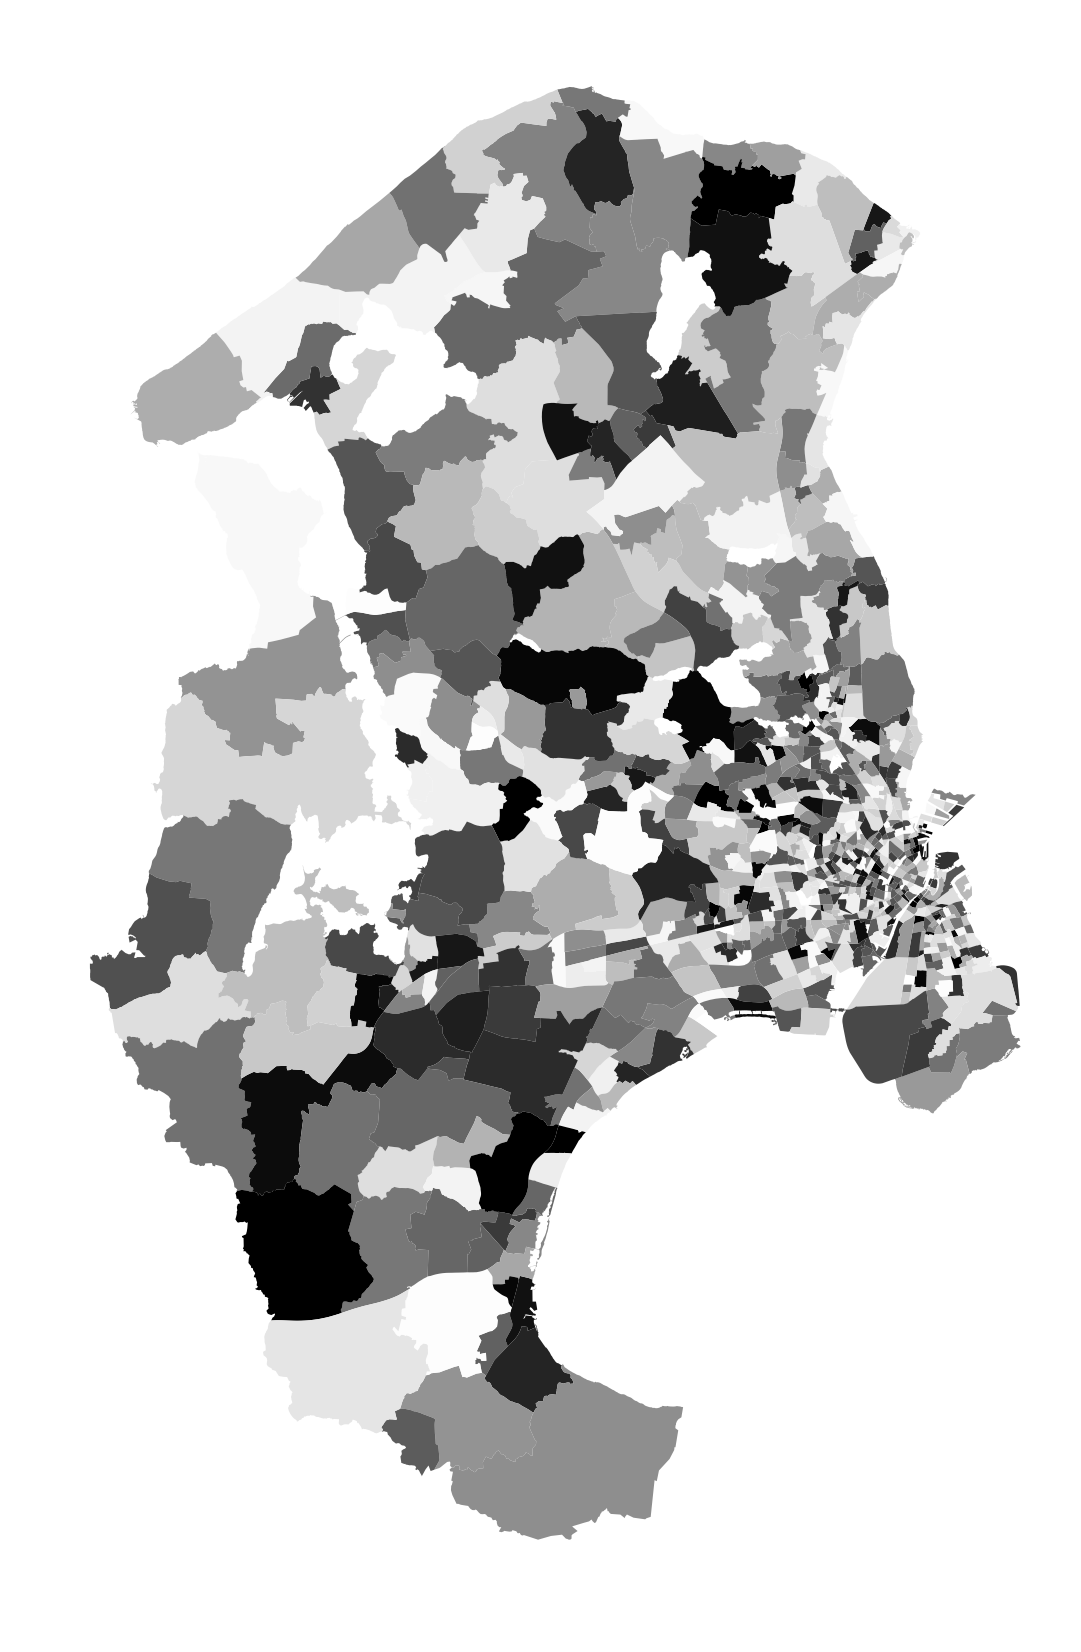

In [49]:
geo_data['random'] = np.random.randint(1, 861, geo_data.shape[0])
#plot on zone numbers
geo_data.plot(column='random', scheme='equal_interval', k=50, linewidth=0.1,
             cmap=plt.cm.Greys, legend=False, figsize=(20,30))
plt.xlim([670000, 735000])
plt.ylim([6130000, 6230000])
plt.xticks([], [])
plt.yticks([], [])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
fig = plt.gcf()
plt.savefig(r'figs/geo_data.pdf', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
                bbox_inches='tight', transparent=True)
plt.savefig(r'figs/geo_data.svg', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
                bbox_inches='tight', transparent=True)
plt.show()

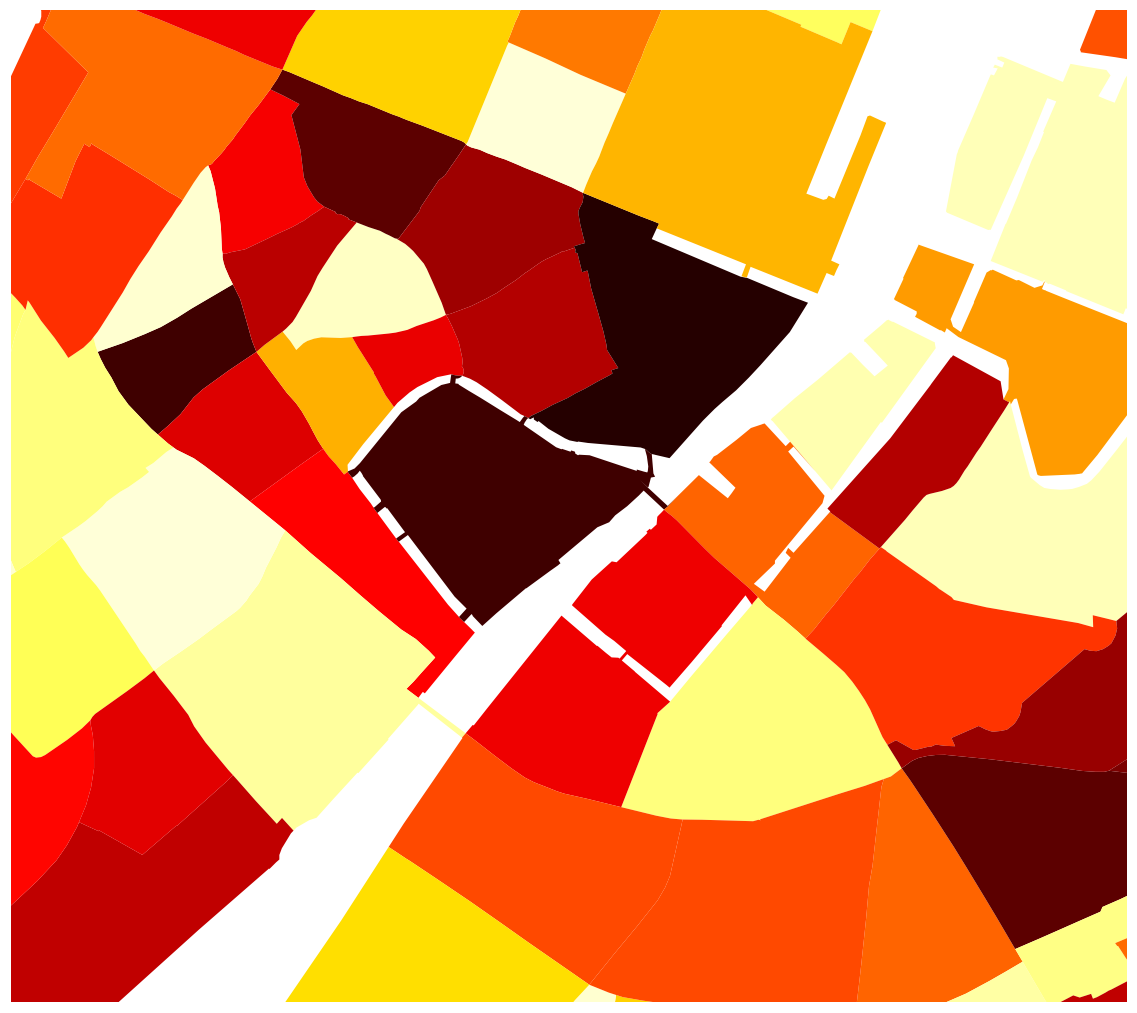

In [98]:
geo_data['random'] = np.random.randint(1, 861, geo_data.shape[0])
#plot on zone numbers
geo_data.plot(column='random', scheme='equal_interval', k=100, linewidth=0.1,
             cmap=plt.cm.hot, legend=False, figsize=(20,30))
plt.xlim([724000, 726700]) 
plt.ylim([6174500, 6176900]) 
plt.xticks([], [])
plt.yticks([], [])
for spine in plt.gca().spines.values():
    spine.set_visible(False)
fig = plt.gcf()
# plt.savefig(r'figs/geo_data_zoom.pdf', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
#                 bbox_inches='tight', transparent=True)
# plt.savefig(r'figs/geo_data_zoom.svg', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
#                 bbox_inches='tight', transparent=True)
plt.show()

In [77]:
#merge geo_data with model outcomes
geo_data_Population = geo_data.merge(df_Population, left_index=True, right_index=True)
geo_data_PopulationDensity = geo_data.merge(df_PopulationDensity, left_index=True, right_index=True)
geo_data_Houses = geo_data.merge(df_Houses, left_index=True, right_index=True)
#geo_data_HousesDensity = geo_data.merge(df_HousesDensity, left_index=True, right_index=True)
geo_data_ResidentialSurface = geo_data.merge(df_ResidentialSurface, left_index=True, right_index=True)
geo_data_FractionResidentialSurface = geo_data.merge(df_FractionResidentialSurface, left_index=True, right_index=True)
geo_data_Jobs = geo_data.merge(df_Jobs, left_index=True, right_index=True)
#geo_data_JobsDensity = geo_data.merge(df_JobsDensity, left_index=True, right_index=True)
geo_data_BusinessSurface = geo_data.merge(df_BusinessSurface, left_index=True, right_index=True)
geo_data_FractionBusinessSurface = geo_data.merge(df_FractionBusinessSurface, left_index=True, right_index=True)
geo_data_AccessibilityJobs = geo_data.merge(df_AccessibilityJobs, left_index=True, right_index=True)
geo_data_Attractiveness = geo_data.merge(df_Attractiveness, left_index=True, right_index=True)
geo_data_TravelDistance = geo_data.merge(df_TravelDistance, left_index=True, right_index=True)
#geo_data_ModalSplitCar = geo_data.merge(df_ModalSplitCar, left_index=True, right_index=True)
geo_data_TrafficVolume = geo_data.merge(df_TrafficVolume, left_index=True, right_index=True)
geo_data_CapacitySaturation = geo_data.merge(df_CapacitySaturation, left_index=True, right_index=True)
geo_data_RoadSurface = geo_data.merge(df_RoadSurface, left_index=True, right_index=True)
geo_data_FractionRoadSurface = geo_data.merge(df_FractionRoadSurface, left_index=True, right_index=True)
geo_data_ParkingPlaces = geo_data.merge(df_ParkingPlaces, left_index=True, right_index=True)
geo_data_ParkingDemand = geo_data.merge(df_ParkingDemand, left_index=True, right_index=True)
geo_data_ParkingSurface = geo_data.merge(df_ParkingSurface, left_index=True, right_index=True)
geo_data_FractionParkingSurface = geo_data.merge(df_FractionParkingSurface, left_index=True, right_index=True)
geo_data_OtherSurface = geo_data.merge(df_OtherSurface, left_index=True, right_index=True)
geo_data_FractionOtherSurface = geo_data.merge(df_FractionOtherSurface, left_index=True, right_index=True)
geo_data_UnallocatedSurface = geo_data.merge(df_UnallocatedSurface, left_index=True, right_index=True)
geo_data_FractionUnallocatedSurface = geo_data.merge(df_FractionUnallocatedSurface, left_index=True, right_index=True)
geo_data_Cars = geo_data.merge(df_Cars, left_index=True, right_index=True)

#geo_data_Population


In [29]:
geo_data

,Zone,Shape_Leng,Shape_Area,geometry
1,1,1103.762734,6.743950e+04,"POLYGON ((724378.7188999997 6175893.0165, 7243..."
2,2,1093.218876,7.526623e+04,"POLYGON ((724702.2747 6175801.282199999, 72457..."
3,3,1086.309761,6.866748e+04,"POLYGON ((724826.1492999997 6176109.288000001,..."
4,4,1051.563246,5.800519e+04,"POLYGON ((724677.2066000002 6176098.779999999,..."
5,5,781.492565,3.234832e+04,"POLYGON ((725094.8020000001 6176020.1633, 7250..."
6,6,1086.720045,6.399796e+04,"POLYGON ((724532.1809999999 6176314.6722, 7245..."
7,7,1375.574554,9.744548e+04,"POLYGON ((724989.0614999998 6176414.6241, 7249..."
8,8,1022.186830,5.166505e+04,"POLYGON ((724785.9495000001 6176409.475199999,..."
9,9,1201.464643,6.304666e+04,"POLYGON ((724270.9578999998 6176094.9011, 7242..."
10,10,1337.758645,1.077586e+05,"POLYGON ((725385.6209000004 6176350.594900001,..."


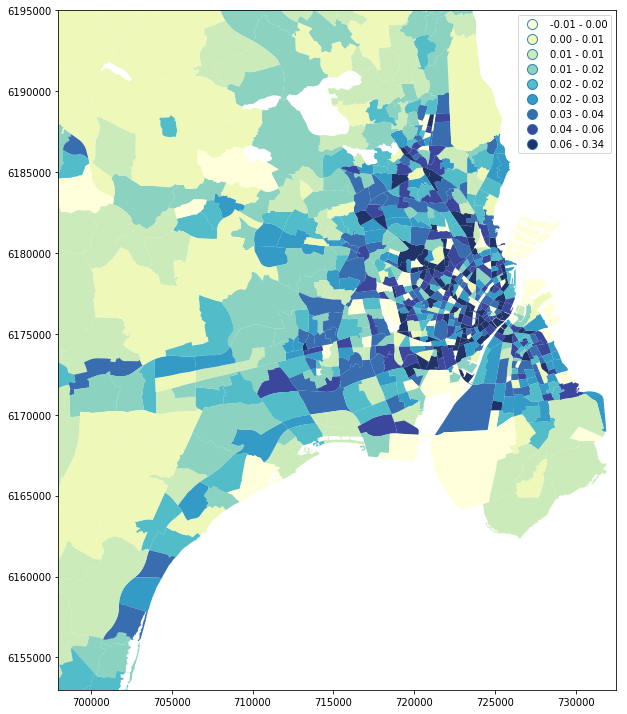

In [89]:
# #plot on zone numbers
# geo_data_Attractiveness.plot(column='Zone', scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1,
#              cmap=plt.cm.YlOrRd, legend=True, figsize=(20,30))
# plt.xlim([670000, 735000])
# plt.ylim([6130000, 6230000])

# plt.show()

geo_data_FractionRoadSurface.plot(column=2050, scheme='quantiles', alpha=0.9, k=9, linewidth=0.1,
                 cmap=plt.cm.YlGnBu, legend=True, figsize=(10,15))
#plt.title("Attractiveness City {}".format(time))
    #to zoom only on the city part of the GCA
plt.xlim([698000, 732500])
plt.ylim([6153000, 6195000])
fig = plt.gcf()
plt.savefig(r'figs/Maps/geo_data_FractionRoadSurface_unwanted_2050.png', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
                 bbox_inches='tight', transparent=False)


plt.show()

In [10]:
import pysal

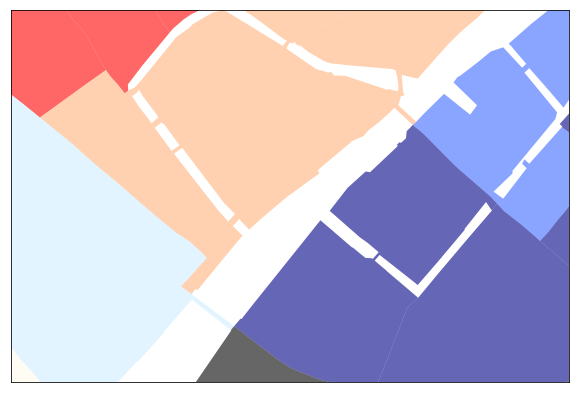

In [76]:
#figure for gimp methodology
geo_data.plot(column='Zone', scheme='equal_interval', alpha=0.6, k=100, 
              linewidth=0.0001, cmap=plt.cm.flag, legend=False, figsize=(10,15))

#plt.title("Attractiveness City {}".format(time))

#to zoom only on the city part of the GCA
plt.xlim([724500, 726000]) 
plt.ylim([6175000, 6176000]) 
plt.xticks([], [])
plt.yticks([], [])
fig = plt.gcf()

plt.savefig(r'figs/Copenhagen zoomed GIMP methodology.png', 
dpi=fig.dpi, 
# dpi value changes how patches behave and are displayed

bbox_inches='tight', transparent=False)
plt.show()

# figure for gimp methodology

geo_data.plot(column='Zone', scheme='fisher_jenks', alpha=0.9, k=86, linewidth=0.1,
                 cmap=plt.cm.gnuplot, legend=False, figsize=(10,15))
#plt.title("Attractiveness City {}".format(time))
    #to zoom only on the city part of the GCA
plt.xlim([723000, 726500])
plt.ylim([6175000, 6177000])
fig = plt.gcf()
#plt.savefig(r'figs/Maps/geo_data_FractionRoadSurface_unwanted_2050.png', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
#                 bbox_inches='tight', transparent=False)


plt.show()

In [ ]:
#plot on attractiveness
geo_data_Attractiveness.plot(column=2015.0, scheme='quantiles', alpha=0.9, k=9, linewidth=0.1, 
                         cmap=plt.cm.YlOrRd, legend=True, figsize=(20,30))
plt.title("Attractiveness 2015")
plt.xlim([698000, 732500])
plt.ylim([6153000, 6195000])
#plt.draw()
fig = plt.gcf()
#plt.savefig(r'figs/geo_data_Attractiveness.png', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
#                 bbox_inches='tight', transparent=True)
plt.show()

# geo_data_Attractiveness.plot(column=2040.0, scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1, 
#                          cmap=plt.cm.YlOrRd, legend=True, figsize=(20,30))
# plt.title("Attractiveness 2040")
# plt.xlim([674000, 733000])
# plt.ylim([6135000, 6226000])
# #plt.draw()
# fig = plt.gcf()
# #plt.savefig(r'figs/geo_data_Attractiveness.png', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
# #                 bbox_inches='tight', transparent=True)
# #plt.show()

# geo_data_Attractiveness.plot(column=2100.0, scheme='fisher_jenks', alpha=0.9, k=9, linewidth=0.1, 
#                          cmap=plt.cm.YlOrRd, legend=True, figsize=(20,30))
# plt.title("Attractiveness 2100")
# plt.xlim([674000, 733000])
# plt.ylim([6135000, 6226000])
# #plt.draw()
# fig = plt.gcf()
# #plt.savefig(r'figs/geo_data_Attractiveness.png', dpi=fig.dpi, # dpi value changes how patches behave and are displayed
# #                 bbox_inches='tight', transparent=True)
# #plt.show()

In [90]:
timeframe = list(outcomes['TIME'].mean(axis=0))

def save_figs(time):
    geo_data_FractionRoadSurface.plot(column=time, scheme='quantiles', alpha=0.9, k=9, linewidth=0.1, 
                 cmap=plt.cm.YlGnBu, legend=True, figsize=(10,15))
    plt.title("Fraction road surface {}".format(time))
    #to zoom only on the city part of the GCA
    plt.xlim([698000, 732500])
    plt.ylim([6153000, 6195000])
    plt.savefig('figs/Maps/Fractionroad unwanted/geo_data_Fractionroad_City_{}.png'.format(time))

In [91]:

for time in timeframe:
    save_figs(time)
    plt.close() #to close the figure

In [ ]:
#Make video for entire gca
filenames = []
for time in timeframe:
    filenames.append('figs/Attractiveness/geo_data_Attractiveness_{}.png'.format(time))

In [ ]:
#make video for copenhagen city
filenames = []
for time in timeframe:
    filenames.append('figs/Attractiveness_City/geo_data_Attractiveness_City_{}.png'.format(time))

In [ ]:
#make a video of the results for entire gca, open with windows media player, don't forget to click the converterwindow
import cv2
import os

image_folder = 'figs/Attractiveness'
video_name = 'video_Attractiveness.avi'

filenames = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, filenames[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, -1, 8, (width,height))

for file in filenames:
    video.write(cv2.imread(os.path.join(image_folder, file)))

cv2.destroyAllWindows()
video.release()

In [ ]:
#make a video of the results for copenhagen city, open with windows media player
import cv2
import os

image_folder = 'figs/Attractiveness_City'
video_name = 'video_Attractiveness_City.avi'

filenames = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, filenames[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, -1, 8, (width,height))

for file in filenames:
    video.write(cv2.imread(os.path.join(image_folder, file)))

cv2.destroyAllWindows()
video.release()

In [ ]:
#plot per type of model outcomes